# Galves-Löcherbach Model in NESTML

_In vivo_, neurons display variability in their spiking behavior: continuous fluctuations of the membrane potential can be observed, and they exhibit spontaneous firing and different responses to the same repeated input stimulus.

To capture these phenomena, the Galves-Löcherbach (GL) model assumes that the firing of the neuron is a random event, whose probability of occurrence in any time step is a firing function $Φ(V_\text{m})$ of membrane potential $V_\text{m}$. By subsuming all sources of randomness into a single function, the GL neuron model simplifies the analysis and simulation of noisy spiking neural networks [1].

By combining the GL neuron model with a synapse model featuring short term synaptic facilitation, we reproduce the results on short-term memory dynamics in state space from [2]. The synapse model is formally equivalent to the Tsodyks-Markram model [3] when set to no depression, only facilitation.

Preliminaries
-------------

In [1]:
%matplotlib inline
from typing import Dict, Optional

import matplotlib as mpl

mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5

import matplotlib.pyplot as plt

import nest
import numpy as np
import os
import random

from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils

import logging
logging.getLogger('matplotlib.font_manager').disabled = True


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0-post0.dev0
 Built: Mar 21 2024 03:47:13

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



GL model with biophysical units
-------------------------------

We formulate the GL model as a linear integrate-and-fire model with membrane time constant $\tau_\text{m}$, resting potential $V_\text{r}$ and an instantaneous jump in the postsynaptic membrane potential upon receiving a spike (Dirac delta function postsynaptic kernel).

In [2]:
# Neuron parameters
params = {
    'tau_m'   : 10.0,
    't_ref'   : 2.0,
    'C_m'     : 250.0,
    'V_r'     : -65.0,
    'V_reset' : -65.0,
    'a'       : 1.2,
    'b'       : 27.0,
    'V_b'     : -51.3
}

In [3]:
nestml_gl_exp_model = """
model gl_exp_neuron:
    state:
        refr_spikes_buffer mV = 0 mV
        refr_tick integer = 0    # Counts number of tick during the refractory period
        V_m mV = V_r     # Membrane potential

    equations:
        kernel G = delta(t)
        V_m' = -(V_m - V_r) / tau_m + (mV / ms) * convolve(G, spikes) + (I_e + I_stim) / C_m

    parameters:
        tau_m   ms   = 10 ms              # Membrane time constant
        C_m     pF   = 250 pF             # Capacity of the membrane
        t_ref   ms   = 2 ms               # Duration of refractory period
        tau_syn ms   = 0.5 ms             # Time constant of synaptic current
        V_r     mV   = -65 mV             # Resting membrane potential
        V_reset mV   = -65 mV             # Reset potential of the membrane
        b     real   = 27                 # Parameter for the exponential curve
        a       mV   = 5 mV               # Parameter for the exponential curve
        V_b mV       = -51.3 mV           # Membrane potential at which Phi(V)=1/b
        reset_after_spike boolean = true

        # constant external input current
        I_e pA = 0 pA

    internals:
        RefractoryCounts integer = steps(t_ref) # refractory time in steps

    input:
        spikes <- spike
        I_stim pA <- continuous

    output:
        spike

    function Phi(V_m mV) real:
        return (1 / b) * exp((V_m - V_b) / a)

    update:
        if refr_tick == 0: # neuron not refractory
            integrate_odes()

        else: # neuron is absolute refractory
            refr_tick -= 1
            
        if random_uniform(0, 1) <= 1E-3 * resolution() * Phi(V_m):
            refr_tick = RefractoryCounts
            if reset_after_spike:
                V_m = V_reset

            emit_spike()
"""

In [4]:
module_name, neuron_model_name = NESTCodeGeneratorUtils.generate_code_for(
    nestml_neuron_model=nestml_gl_exp_model,
    logging_level="ERROR"  # try "DEBUG" for more debug information
)

nest.Install(module_name)


Did you try to import pygsl in the build directory?

Well, that does not work out of the box. If you want to do that, please
use
      python setup.py build_ext -i
to add the necessary extension module in the local pygsl/ directory!

Please read the README first! Any further questions or missing information
please report on https://github.com/pygsl/pygsl!



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0-post0.dev0
 Built: Mar 21 2024 03:47:13

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

-- The CXX compiler identification is GNU 10.2.1
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done

-------------------------------------------------------
nestml_84ffa9d0eb074a75aff4c599b4aedcfe_module Configuration Summary
-------------------------------------------------------

C++ compiler         : /usr/bin/c++
Build static libs    : OFF
C++ compiler flags   : 
NEST compiler flags  :  -std=c++17 -Wall -fopenmp -O2 -fdiagnostics-color=auto
NEST include dirs    :  -I/home/charl/nest-simulato

### Firing rate

This should correspond to the $\Phi(V_\text{m})$ function in the neuron (see plot below for the theoretical curve). Please note that in the literature, $\Phi$ is sometimes defined as a probability of firing function with values between 0 and 1, but we here define it as giving the firing rate (in units of s${}^{-1}$).

In [5]:
def measure_numerical_Phi_function(neuron_model_name, module_name, V_min=0., V_max=10., neuron_model_params=None, neuron_membrane_potential_name="V_m"):
    nest.ResetKernel()
    nest.Install(module_name)
    nest.resolution = 1.   # check that results are independent of resolution...

    t_stop = 25000.
    
    V_range = np.linspace(V_min, V_max, 12)
    n_spikes = np.nan * np.ones_like(V_range)
    for i, V_m in enumerate(V_range):
        neuron = nest.Create(neuron_model_name)
        if neuron_model_params:
            neuron.set(neuron_model_params)
            
        neuron.set({neuron_membrane_potential_name: V_m})
   
        sr = nest.Create('spike_recorder')
        nest.Connect(neuron, sr)
    
        assert neuron.get(neuron_membrane_potential_name) == V_m
        nest.Simulate(t_stop)
        assert neuron.get(neuron_membrane_potential_name) == V_m
    
        n_spikes[i] = len(sr.events["times"])
    
    spike_rate = n_spikes / (t_stop / 1E3)

    return V_range, spike_rate


Aug 26 09:55:55 Install [Info]: 
    loaded module nestml_84ffa9d0eb074a75aff4c599b4aedcfe_module

Aug 26 09:55:55 correlation_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Aug 26 09:55:55 correlomatrix_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Aug 26 09:55:55 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 1 ms

Aug 26 09:55:55 gl_exp_neuron_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Aug 26 09:55:55 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 1 ms.

Aug 26 09:55:55 NodeManager::prepare_nodes [Info]: 
    Preparing 2 nodes for simulation.

Aug 26 09:55:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2
    Simulation time (ms): 25000
    Number of OpenMP threads: 1
    Not using MPI

Aug 26 09:55:55 SimulationManager::run [Info]: 
    Simulation finished.

A

Text(0, 0.5, 'Firing rate [Hz]')

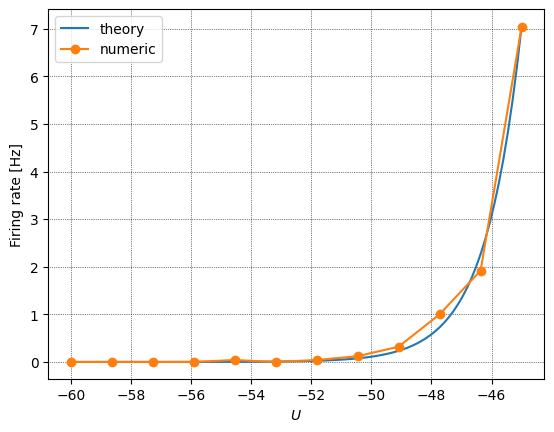

In [6]:
# theoretical Phi vs V_m
V_range_theory = np.linspace(-60., -45., 100)
Phi_of_V_theory = (1 / params['b']) * np.exp((V_range_theory - params['V_b']) / params['a'])

# numerical Phi vs V_m
V_range_numeric, spike_rate_numeric = measure_numerical_Phi_function(neuron_model_name=neuron_model_name,
                                                                     module_name=module_name,
                                                                     V_min=-60.,
                                                                     V_max=-45.,
                                                                     neuron_model_params={"reset_after_spike": False,
                                                                                          "a": params['a'],
                                                                                          "b": params['b'],
                                                                                          "V_b": params['V_b'],
                                                                                          "tau_m": 1E99})

fig, ax = plt.subplots()
ax.plot(V_range_theory, Phi_of_V_theory, label="theory")
ax.plot(V_range_numeric, spike_rate_numeric, marker="o", label="numeric")
ax.legend()
ax.set_xlabel("$U$")
ax.set_ylabel("Firing rate [Hz]")

## Computing reliability of the single neuron model

Here we plot the spike times for the neurons as a raster plot to study the stochastic behavior of the neuron model. First, we give the neurons a constant input current and then a Poissonian input.

We observe that with the constant input current, the spike times across trials are highly variable, and the firing rate at the bottom is “flat” indicating that the spike times are not reliably reproduced over trials. With the Poissonian input, the corresponding firing rate panel shows several peaks indicating that the spike times tend to be more repeatable across trials.

In [7]:
def evaluate_neuron(neuron_name, module_name, nneurons=1, neuron_parms=None, stimulus_type="constant", poisson_fr=0.0,
                    mu=500., sigma=0., t_sim=300., plot=False, rseed=1000, dt=0.1, input_freq=0.0):
    """
    Run a simulation in NEST for the specified neuron. Inject a stepwise
    current and plot the membrane potential dynamics and spikes generated.
    """
    nest.ResetKernel()
    nest.Install(module_name)
    nest.SetKernelStatus({'rng_seed': rseed,
                          'resolution': dt})
    neuron = nest.Create(neuron_name, nneurons)
    if neuron_parms:
        for k, v in neuron_parms.items():
            nest.SetStatus(neuron, k, v)
    nest.SetStatus(neuron,{'V_m':np.random.uniform(-65.0, -50.0)})

    if stimulus_type == "noise":
        # Create a noise generator
        noise = nest.Create("noise_generator")
        # Set the parameters of the noise generator
        noise_params = {"mean": mu, 
                        "std": sigma, 
                        "dt": dt,
                        "frequency":input_freq}
        nest.SetStatus(noise, noise_params)
        nest.Connect(noise, neuron)

    elif stimulus_type == "poisson_spikes":
        # Create a Poisson generator device
        poisson = nest.Create("poisson_generator", params={"rate": poisson_fr})

        # Create a parrot neuron
        parrot = nest.Create("parrot_neuron")

        # Connect the Poisson generator to the parrot neuron
        nest.Connect(poisson, parrot)

        # Connect the parrot neuron to each neuron
        nest.Connect(parrot, neuron)
    else:
        assert stimulus_type == "constant"
        nest.SetStatus(neuron, "I_e", mu)

    multimeter = nest.Create("multimeter")
    multimeter.set({"record_from": ["V_m"],
                    "interval": dt})
    spike_recorder = nest.Create("spike_recorder")
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spike_recorder)

    nest.Simulate(t_sim)

    dmm = nest.GetStatus(multimeter)[0]
    Voltages = dmm["events"]["V_m"]
    tv = dmm["events"]["times"]
                        
    dSD = nest.GetStatus(spike_recorder, keys='events')[0]
    ns = dSD['senders']
    ts = dSD["times"]

    _idx = [np.argmin((tv - spike_time)**2) - 1 for spike_time in ts]
    V_m_at_spike_times = Voltages[_idx]

    if plot:
        fig, ax = plt.subplots()
        ax.plot(tv, Voltages)
        ax.scatter(ts, V_m_at_spike_times)
        ax.set_xlabel("Time [ms]")
        ax.set_ylabel("V_m [mV]")
        ax.grid()

    return ts, ns


Aug 26 09:55:56 Install [Info]: 
    loaded module nestml_84ffa9d0eb074a75aff4c599b4aedcfe_module

Aug 26 09:55:56 gl_exp_neuron_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Aug 26 09:55:56 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Aug 26 09:55:56 NodeManager::prepare_nodes [Info]: 
    Preparing 52 nodes for simulation.

Aug 26 09:55:56 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 52
    Simulation time (ms): 500
    Number of OpenMP threads: 1
    Not using MPI

Aug 26 09:55:56 SimulationManager::run [Info]: 
    Simulation finished.

Aug 26 09:55:56 Install [Info]: 
    loaded module nestml_84ffa9d0eb074a75aff4c599b4aedcfe_module

Aug 26 09:55:56 gl_exp_neuron_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Aug 26 09:55:56 SimulationManager::set_status [I

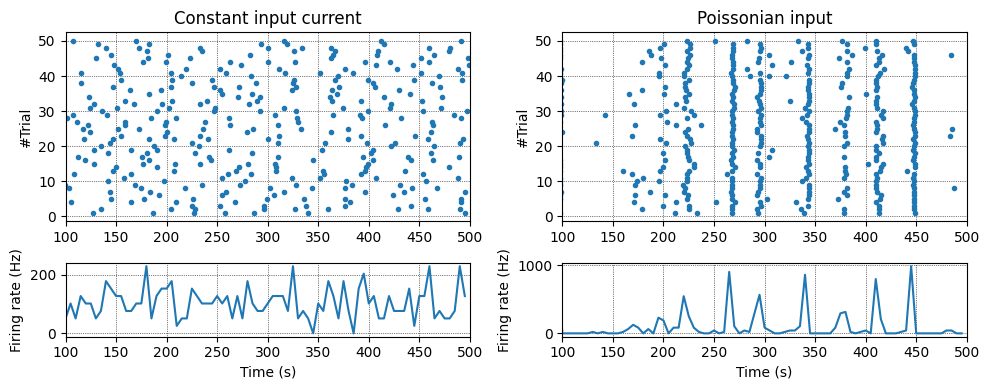

In [8]:
dt = 0.1
nneurons = 50

ts_const, ns_const = evaluate_neuron(neuron_model_name,
                                     module_name,
                                     nneurons=nneurons,
                                     neuron_parms=params,
                                     stimulus_type='constant',
                                     mu=550.,
                                     t_sim=500.0,
                                     dt=dt,
                                     poisson_fr=0.0)

ts_noise, ns_noise = evaluate_neuron(neuron_model_name,
                                     module_name,
                                     nneurons=nneurons,
                                     neuron_parms=params,
                                     stimulus_type='poisson_spikes',
                                     t_sim=500.0,
                                     poisson_fr=2000.0)

# PSTH parameters
t_start = 0.0
t_stop = 500.0
t_step = 5.0
t_bins = np.arange(t_start, t_stop + t_step, t_step)

# Calculate the PSTH
psth_const, _ = np.histogram(ts_const, bins=t_bins)
psth_const = psth_const / len(ts_const) / (dt*1e-3)  # divide by number of trials and time bin size

psth_noise, _ = np.histogram(ts_noise, bins=t_bins)
psth_noise = psth_noise / len(ts_noise) / (dt*1e-3)  # divide by number of trials and time bin size

plt.figure(figsize=(10,4))
# Raster plot
plt.subplot2grid((3,2),(0,0), rowspan=2)
plt.plot(ts_const, ns_const, '.')
plt.xlim(100, 500)
plt.ylabel('#Trial')
plt.title('Constant input current')

plt.subplot2grid((3,2),(0,1), rowspan=2)
plt.plot(ts_noise, ns_noise, '.')
plt.xlim(100, 500)
plt.ylabel('#Trial')
plt.title('Poissonian input')

# Plot the PSTH
plt.subplot2grid((3,2),(2,0), rowspan=1)
plt.plot(t_bins[:-1], psth_const)
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (Hz)')
plt.xlim(100, 500)

plt.subplot2grid((3,2),(2,1), rowspan=1)
plt.plot(t_bins[:-1], psth_noise)
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (Hz)')
plt.xlim(100, 500)
plt.tight_layout()

Normalized model with calcium dynamics
--------------------------------------

For convenience, we normalize the parameters and dynamical equations of the previous model with biophysical units, to make a model where all variables and parameters are scalars.

In [9]:
nestml_gl_ca_neuron_model = '''
model gl_ca_neuron:
    state:
        U real = 0     # membrane potential

    parameters:
        a real = 3.
        alpha_over_N real = 1.0777744654743957   # synaptic strength
        beta real = 50     # membrane potential leak
        reset_after_spike boolean = true

    input:
        incoming_spikes <- spike

    output:
        spike

    function Phi(U real) real:
        if U <= 0:
            return 0

        return (4 * a) / (1 + exp(a - U)) - (4 * a) / (1 + exp(a))

    equations:
        kernel K = delta(t)
    
        # R is presynaptic neuron's R and is passed as the spike weight by the synapse
        U' = -U / (1E3 / beta) + alpha_over_N * convolve(K, incoming_spikes) / ms

    update:
        # integrate spike input
        integrate_odes()

        # emit spike?
        if random_uniform(0, 1) <= 1E-3 * resolution() * Phi(U):
            emit_spike()
            if reset_after_spike:
                U = 0   # reset membrane potential
'''

We now formulate the facilitating synapse model. The `R_pre` variable represents the calcium concentration of the presynaptic neuron. For convenience (and at the cost of some redundancy), we store it here in the NEST synapse object. The decay time constant of the calcium concentration is given by the `lmbda` parameter.

In [10]:
nestml_gl_ca_synapse_model = '''
model syn_gl_ca_synapse:
    state:
        R_pre real = 0.
        w real = 1.   # weight variable

    parameters:
        d ms = 1 ms
        lmbda real = 2.1555489309487914     # residual calcium decay rate

    onReceive(incoming_spikes):
        w = R_pre
        R_pre += 1
        emit_spike(w, d)

    input:
        incoming_spikes <- spike
  
    output:
        spike
  
    update:
        R_pre *= exp(-lmbda * 1E-3 * resolution())   # leakage
'''

With the neuron and synapse models defined, we generate the code and load the extension module into NEST:

In [11]:
module_name, neuron_model_name, synapse_model_name = NESTCodeGeneratorUtils.generate_code_for(
    nestml_neuron_model=nestml_gl_ca_neuron_model,
    nestml_synapse_model=nestml_gl_ca_synapse_model,
    codegen_opts={"delay_variable": {"syn_gl_ca_synapse": "d"},
                  "weight_variable": {"syn_gl_ca_synapse": "w"}},
    logging_level="ERROR"  # try "DEBUG" for more debug information
)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0-post0.dev0
 Built: Mar 21 2024 03:47:13

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

-- The CXX compiler identification is GNU 10.2.1
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done

-------------------------------------------------------
nestml_24a1d5e6286c4f26852138f442b8afc8_module Configuration Summary
-------------------------------------------------------

C++ compiler         : /usr/bin/c++
Build static libs    : OFF
C++ compiler flags   : 
NEST compiler flags  :  -std=c++17 -Wall -fopenmp -O2 -fdiagnostics-color=auto
NEST include dirs    :  -I/home/charl/nest-simulato

### Firing rate

This should correspond to the `Phi(U)` function in the neuron (see plot below for the theoretical curve).


Aug 26 09:56:10 Install [Info]: 
    loaded module nestml_24a1d5e6286c4f26852138f442b8afc8_module

Aug 26 09:56:10 correlation_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Aug 26 09:56:10 correlomatrix_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Aug 26 09:56:10 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 1 ms

Aug 26 09:56:10 gl_ca_neuron_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Aug 26 09:56:10 gl_ca_neuron_nestml__with_syn_gl_ca_synapse_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Aug 26 09:56:10 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 1 ms.

Aug 26 09:56:10 NodeManager::prepare_nodes [Info]: 
    Preparing 2 nodes for simulation.

Aug 26 09:56:10 SimulationManager::start_updating_ [Info]: 
    

Text(0, 0.5, 'Firing rate [Hz]')

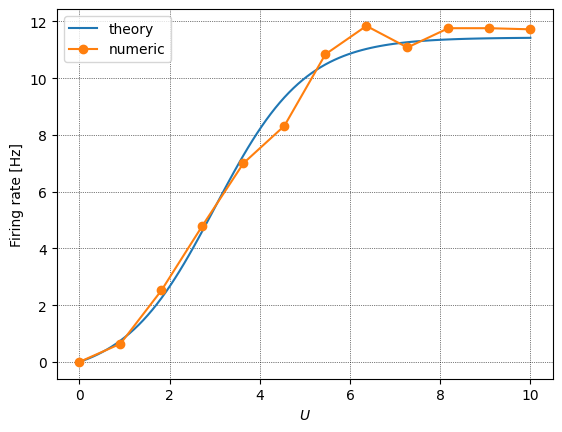

In [12]:
#theoretical Phi vs U
a = 3
U_range_theory = np.linspace(0., 10., 100)
Phi_of_U_theory = (4 * a) / (1 + np.exp(a - U_range_theory)) - (4 * a) / (1 + np.exp(a))

# numerical Phi vs U
U_range_numeric, spike_rate_numeric = measure_numerical_Phi_function(neuron_model_name=neuron_model_name,
                                                                     module_name=module_name,
                                                                     neuron_model_params={"reset_after_spike": False,
                                                                                          "beta": 1E-99,   # a very low value, to prevent the membrane potential from decaying
                                                                                          "a": 3.},
                                                                     neuron_membrane_potential_name="U")

fig, ax = plt.subplots()
ax.plot(U_range_theory, Phi_of_U_theory, label="theory")
ax.plot(U_range_numeric, spike_rate_numeric, marker="o", label="numeric")
ax.legend()
ax.set_xlabel("$U$")
ax.set_ylabel("Firing rate [Hz]")

### Postsynaptic response

When a neuron spikes, it increases the potential of each postsynaptic partner by $\alpha R/N$. Note that due to the residual calcium dynamics, the synapse is facilitating.

In [13]:
def measure_postsynaptic_response(neuron_model: str,
                                  synapse_model: str,
                                  module_name: str,
                                  t_stop: float = 2250.,
                                  V_m_specifier: str = "V_m",
                                  custom_model_opts: Optional[Dict] = None):

    spike_times = np.array([100., 200., 250., 2000.])
    
    nest.ResetKernel()
    nest.Install(module_name)
    neuron = nest.Create(neuron_model, params=custom_model_opts)
    neuron.alpha_over_N = 1E-6   # a very low value, to prevent the neuron from spiking
    spike_generator = nest.Create("spike_generator", params={"spike_times": spike_times})
    nest.Connect(spike_generator, neuron, syn_spec={'synapse_model': synapse_model})

    multimeter = nest.Create('multimeter')
    nest.SetStatus(multimeter, {"record_from": [V_m_specifier]})
    nest.Connect(multimeter, neuron)

    sr = nest.Create('spike_recorder')
    nest.Connect(neuron, sr)

    nest.Simulate(t_stop)

    ts = multimeter.events["times"]
    Vms = multimeter.events[V_m_specifier]
    
    return ts, Vms


Aug 26 09:56:10 Install [Info]: 
    loaded module nestml_24a1d5e6286c4f26852138f442b8afc8_module

Aug 26 09:56:10 NodeManager::prepare_nodes [Info]: 
    Preparing 4 nodes for simulation.

Aug 26 09:56:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4
    Simulation time (ms): 2250
    Number of OpenMP threads: 1
    Not using MPI

Aug 26 09:56:10 SimulationManager::run [Info]: 
    Simulation finished.


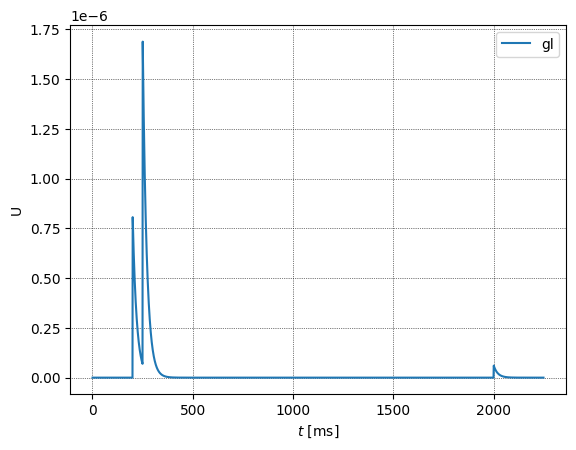

In [14]:
ts, Vms_gl = measure_postsynaptic_response(neuron_model_name,
                                           synapse_model_name,
                                           module_name,
                                           V_m_specifier="U")

fig, ax = plt.subplots()
ax.set_xlabel("$t$ [ms]")
ax.plot(ts, Vms_gl, label="gl")
ax.set_ylabel("U")
ax.legend()

### Network dynamics

We now set up the network with 100 neurons and check that it reaches a non-quiescent equilibrium state, following [4].

In [15]:
def run_simulation_in_chunks(sim_chunks, sim_time, syn_recordables, neurons):
    sim_time_per_chunk = sim_time / sim_chunks

    # Init log to collect the values of all recordables
    log = {}
    log["t"] = []

    # Initialize all the arrays
    # Additional one entry is to store the trace value before the simulation begins
    for rec in syn_recordables:
        log[rec] = (sim_chunks + 1) * [[]]

    # Get the value of trace values before the simulation
    syn = nest.GetConnections(target=neurons, synapse_model=synapse_model_name)
    print(str(len(syn)) + " synapses in the network")
    for rec in syn_recordables:
        log[rec][0] = syn.get(rec)
        
    log["t"].append(nest.GetKernelStatus("biological_time"))

    # Run the simulation in chunks
    for i in range(sim_chunks):
        sim_start_time = i * sim_time_per_chunk
        sim_end_time = sim_start_time + sim_time_per_chunk

        nest.Simulate(np.round(sim_time/sim_chunks))
        
        # log current values
        log["t"].append(nest.GetKernelStatus("biological_time"))

        # Get the value of trace after the simulation
        for rec in syn_recordables:
            log[rec][i + 1] = syn.get(rec).copy()
            
    #nest.Cleanup()
    
    return log


In [16]:
N = 100      # Number of neurons in network XXX: 1000 in the original paper
conn_prob = 1.

a = 2.

beta = 50.
lmbda = 10.
alpha = beta * lmbda

U_0 = 1. #0.79555   # initial membrane potential
R_0 = .2 #1.   # initial residual calcium

U_range = .1 * U_0
R_range = .1 * R_0

In [17]:
nest.ResetKernel()
nest.Install(module_name)
nest.resolution = .1 # [ms]

sim_time = 1000.   # [ms] (was 120 seconds in original paper)
chunk_length = 10.   # [ms]
n_chunks = int(sim_time / chunk_length)
syn_recordables = ["R_pre"]

pop = nest.Create(neuron_model_name, N)
pop.a = a
pop.alpha_over_N = alpha / N
pop.beta = beta
pop.U = [U_0 + U_range * (random.random() - .5) for _ in range(N)]

conn_spec_dict = {'rule': 'pairwise_bernoulli', 'p': conn_prob, 'allow_autapses': False}
nest.Connect(pop, pop, conn_spec_dict, syn_spec={'synapse_model': synapse_model_name, 'lmbda': lmbda})

syn = nest.GetConnections(target=pop, synapse_model=synapse_model_name)
N_syn = len(syn)
syn.R_pre = [R_0 + R_range * (random.random() - .5) for _ in range(N_syn)]

multimeter = nest.Create("multimeter")
multimeter.set({"record_from": ["U"], "interval": nest.resolution})
nest.Connect(multimeter, pop)

sr = nest.Create('spike_recorder')
nest.Connect(pop, sr)

log = run_simulation_in_chunks(n_chunks, sim_time, syn_recordables, pop)


Aug 26 09:56:11 Install [Info]: 
    loaded module nestml_24a1d5e6286c4f26852138f442b8afc8_module

Aug 26 09:56:11 gl_ca_neuron_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Aug 26 09:56:11 gl_ca_neuron_nestml__with_syn_gl_ca_synapse_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Aug 26 09:56:11 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Aug 26 09:56:11 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.
9900 synapses in the network

Aug 26 09:56:11 NodeManager::prepare_nodes [Info]: 
    Preparing 102 nodes for simulation.

Aug 26 09:56:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 102
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Text(0.5, 0.98, 'R')

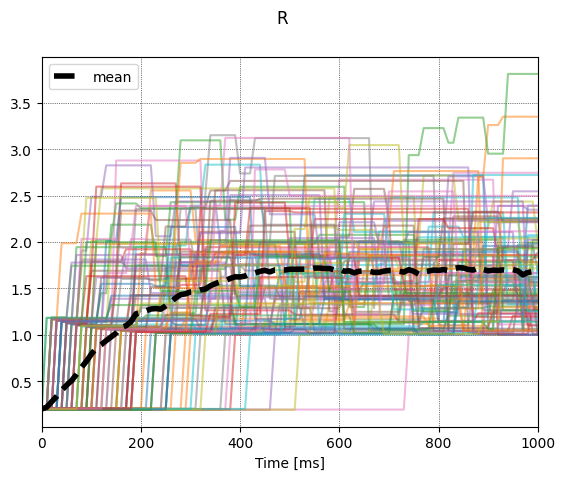

In [18]:
times = log["t"]
R_pre = np.array(log["R_pre"])
R_pre_avg = np.mean(R_pre, axis=1)

fig, ax = plt.subplots()
ax.plot(times, R_pre[:, ::N], alpha=.5)   # XXX: plot only every N-th line
ax.set_xlim(0, sim_time)
ax.set_xlabel("Time [ms]")
ax.plot(times, R_pre_avg, linewidth=4, linestyle="--", c="black", label="mean")
ax.legend()
fig.suptitle("R")

Text(0, 0.5, 'Neuron')

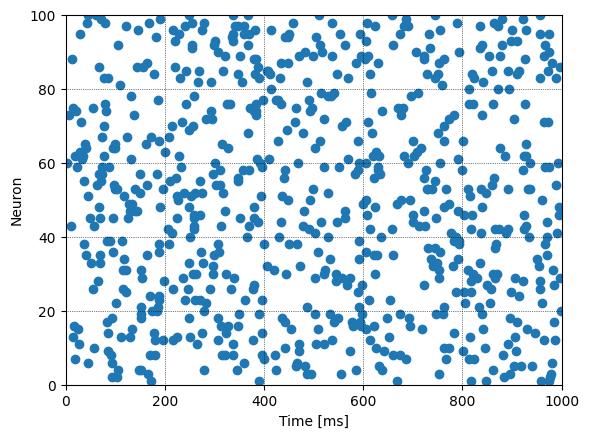

In [19]:
fig, ax = plt.subplots()
ax.scatter(sr.events["times"], sr.events["senders"])
ax.set_ylim(0, N)
ax.set_xlim(0, sim_time)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Neuron")

In [20]:
avg_firing_rate = len(sr.events["times"]) / N / (sim_time / 1E3)
print("Network average firing rate: " + str(avg_firing_rate) + " Hz")

Network average firing rate: 7.1 Hz


Text(0.5, 0.98, 'U')

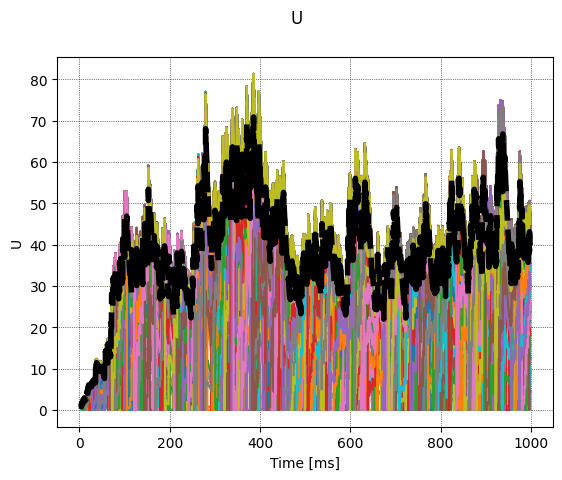

In [21]:
neuron_ids = np.unique(multimeter.get("events")["senders"])

fig, ax = plt.subplots()

U_avg = np.zeros(len(np.unique(multimeter.get("events")["times"])))
for neuron_id in range(1, N+1):
    idx = np.where(neuron_id == multimeter.get("events")["senders"])
    times = multimeter.get("events")["times"][idx]
    U = multimeter.get("events")["U"][idx]
    
    U_avg += U / N

    if neuron_id < 100:
        ax.plot(times, U, label="U")

ax.plot(times, U_avg, linewidth=4, linestyle="--", c="black")
ax.set_ylabel("U")
ax.set_xlabel("Time [ms]")
fig.suptitle("U")

### Comparison to theory

We now check that the average neuron state in the network returns to the equilibrium position after an initial transient [2].

(0.01, 6)

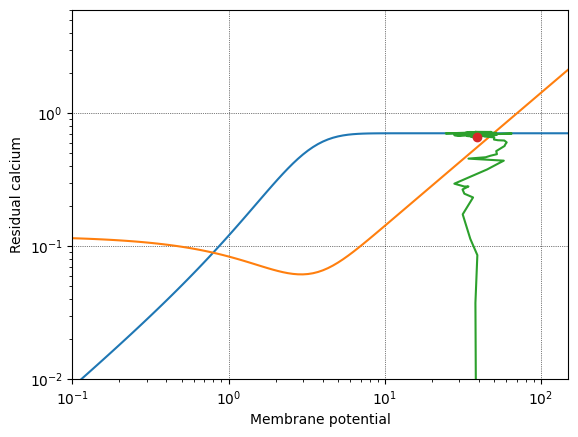

In [22]:
def Phi(x):
    return (4 * a) / (1 + np.exp(a - x)) - (4 * a) / (1 + np.exp(a))

def nullcline1(x):
    return Phi(x) / lmbda

def nullcline2(x):
    return beta / alpha * x / Phi(x)

U_vec = np.logspace(np.log10(.1), np.log10(150), 100)

nullcline1_vec = nullcline1(U_vec)
nullcline2_vec = nullcline2(U_vec)

fig, ax = plt.subplots()
ax.loglog(U_vec, nullcline1_vec)
ax.loglog(U_vec, nullcline2_vec)

U_avg_intrp = np.interp(np.linspace(0, len(U_avg), 100),
                        np.arange(len(U_avg)),
                        U_avg)

R_pre_intrp = np.interp(np.linspace(0, len(R_pre_avg), 100),
                        np.arange(len(R_pre_avg)),
                        R_pre_avg)

R_pre_intrp[ R_pre_intrp <= 1] = 1.000001

ax.loglog(U_avg_intrp, R_pre_intrp - 1)
ax.loglog(U_avg[-1], R_pre_avg[-1] - 1, marker="o")

ax.set_xlabel('Membrane potential')
ax.set_ylabel('Residual calcium')
ax.set_xlim(np.amin(U_vec), np.amax(U_vec))
ax.set_ylim(.01, 6)

## Acknowledgements

The authors would like to thank Renan Shimoura, Christophe Pouzat, Antonio Roque and Antonio Galves for their kind and helpful discussion and feedback.


## References

[1] Brochini, L., de Andrade Costa, A., Abadi, M. et al. Phase transitions and self-organized criticality in networks of stochastic spiking neurons. Sci Rep 6, 35831 (2016). https://doi.org/10.1038/srep35831

[2] Antonio Galves, Eva Löcherbach, Christophe Pouzat, Errico Presutti, "A system of interacting neurons with short term synaptic facilitation". arXiv:1903.01270v3 13 Sep 2019

[3] Tsodyks MV, Markram H (1997). The neural code between neocortical pyramidal neurons depends on neurotransmitter release probability. PNAS, 94(2):719-23. DOI: https://doi.org/10.1073/pnas.94.2.719

[4] Christophe Pouzat (2020). Spike Train Analysis and Modeling. (Syllabus) Latin-American School on Computational Neuroscience (LASCON) 2020, São Paulo, Brazil.

[5] https://plmlab.math.cnrs.fr/xtof/interacting_neurons_with_stp


## Copyright

This file is part of NEST.

Copyright (C) 2004 The NEST Initiative

NEST is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

NEST is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with NEST.  If not, see <http://www.gnu.org/licenses/>.
